<a href="https://colab.research.google.com/github/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis/blob/main/experiments/inceptionNetMCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InceptionNetV3 Experiments with Monte Carlo Dropout

## Import libraries and data

In [ ]:
import os
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
import keras
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CLONE GITHUB REPOSITORY
!rm -r "COVID-Chest-X-Rays-Deep-Learning-analysis"
!git clone https://github.com/Gialbo/COVID-Chest-X-Rays-Deep-Learning-analysis.git

rm: cannot remove 'COVID-Chest-X-Rays-Deep-Learning-analysis': No such file or directory
Cloning into 'COVID-Chest-X-Rays-Deep-Learning-analysis'...
remote: Enumerating objects: 1488, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 1488 (delta 0), reused 1 (delta 0), pack-reused 1485
Receiving objects: 100% (1488/1488), 141.34 MiB | 25.49 MiB/s, done.
Resolving deltas: 100% (783/783), done.


In [ ]:
# LOAD DIRECTORIES
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/models')
sys.path.append('COVID-Chest-X-Rays-Deep-Learning-analysis/tools')

In [ ]:
# LOAD TRAINING DATA

from XRaysDataset import XRaysDataset

dataset = XRaysDataset(img_height=224, img_width=224, isInceptionNet=True)
train_ds, val_ds = dataset.load(train_val_split=True)

test_dir = '/content/drive/MyDrive/BIOINF/covid-project/dataset/test'
dataset = XRaysDataset(dir=test_dir, img_height=224,img_width=224, isInceptionNet=True)
test_ds, test_size = dataset.load(separate_classes=False)

Number of batches for the train dataset: 22
Number of batches for the validation dataset: 6
Dataset size  383
Number of batches for the dataset: 3


## Training

In [ ]:
from inceptionNetMCD import inceptionNetMCD
from plotter import plot_losses, plot_accuracies, plot_recalls, plot_precisions

In [ ]:
batch_size = 128
earlystopping = EarlyStopping(
    patience = 10
)

checkpoint_path = os.path.join('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/MCD/weights.hdf5')

checkpointer = ModelCheckpoint(
    filepath = checkpoint_path, 
    save_best_only = True
)

model = inceptionNetMCD()
history = model.fit(
    train_ds,
    validation_data = val_ds,
    batch_size = batch_size,
    epochs = 100, 
    callbacks = [earlystopping, checkpointer]
)

Epoch 1/100
22/22 [==============================] - 25s 716ms/step - loss: 1.0895 - accuracy: 0.4632 - recall_6: 0.2878 - recall_7: 0.3432 - recall_8: 0.0827 - precision_6: 0.6020 - precision_7: 0.5952 - precision_8: 0.3902 - val_loss: 2.8783 - val_accuracy: 0.3125 - val_recall_6: 0.9754 - val_recall_7: 0.0305 - val_recall_8: 0.0135 - val_precision_6: 0.3046 - val_precision_7: 0.5000 - val_precision_8: 0.6000
Epoch 2/100
22/22 [==============================] - 13s 610ms/step - loss: 0.5932 - accuracy: 0.7659 - recall_6: 0.7099 - recall_7: 0.8596 - recall_8: 0.6474 - precision_6: 0.7824 - precision_7: 0.8632 - precision_8: 0.6925 - val_loss: 13.0870 - val_accuracy: 0.2951 - val_recall_6: 1.0000 - val_recall_7: 0.0000e+00 - val_recall_8: 0.0000e+00 - val_precision_6: 0.2951 - val_precision_7: 0.0000e+00 - val_precision_8: 0.0000e+00
Epoch 3/100
22/22 [==============================] - 13s 606ms/step - loss: 0.3431 - accuracy: 0.8882 - recall_6: 0.9025 - recall_7: 0.8965 - recall_8: 0.8

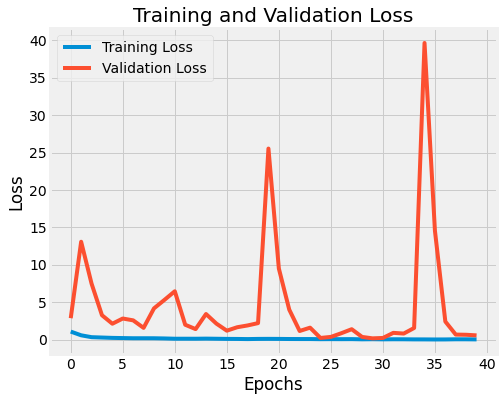

In [ ]:
plot_losses(history, isMCD=True)

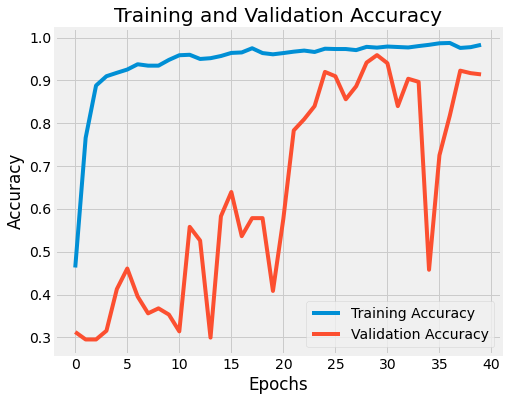

In [ ]:
plot_accuracies(history, isMCD=True)

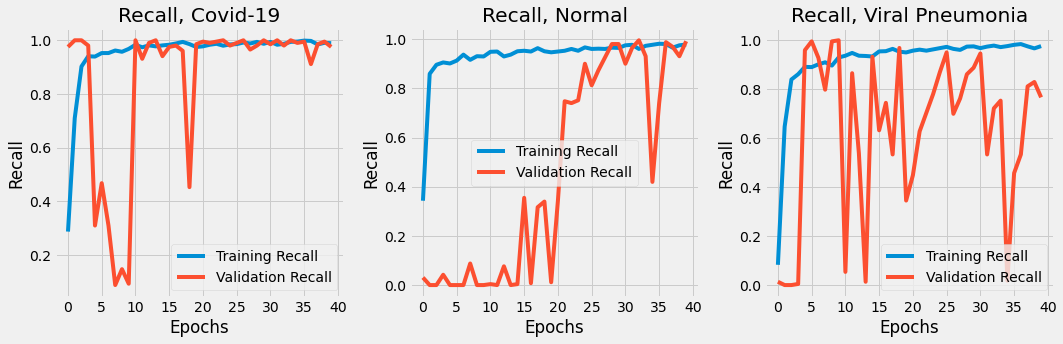

In [ ]:
plot_recalls(history, isMCD=True)

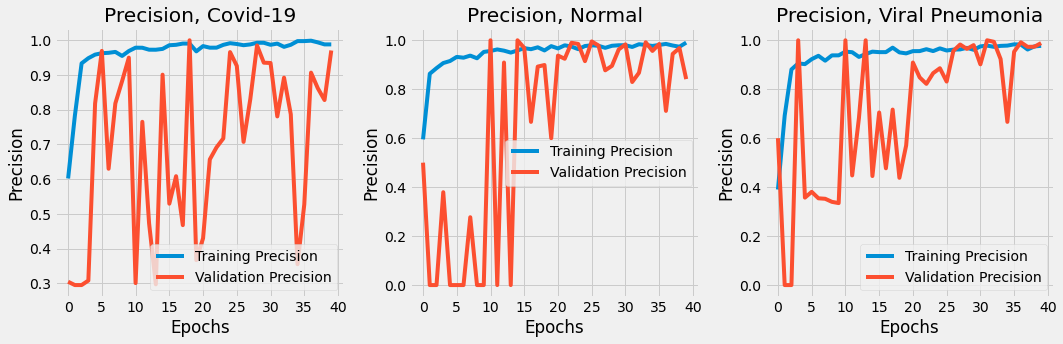

In [ ]:
plot_precisions(history, isMCD=True)

## Evaluation

In [ ]:
def evaluate_model(checkpoint_dir, test_ds, n_trials=5, baseline=False):
  tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
  results = {}

  if baseline:
    weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/MCD/weights.hdf5'
    classification_model = inceptionNetMCD()
    classification_model.load_weights(weights_path)
  else:
    classification_model = inceptionNetMCD()
    checkpoint = tf.train.Checkpoint(model=classification_model)
    best = tf.train.latest_checkpoint(checkpoint_dir)
    print(best)
    checkpoint.restore(best)

  for i in range(n_trials):
    results[str(i+1)] = []

    print("--------------- TRIAL " + str(i+1) + " --------------- ")
    results[str(i+1)] = classification_model.evaluate(test_ds, verbose=2)

  # SHOW CLASSIFICATION REPORT

  loss = np.zeros(n_trials)
  accuracy = np.zeros(n_trials)
  recall_covid = np.zeros(n_trials)
  recall_normal = np.zeros(n_trials)
  recall_viral_pneumonia = np.zeros(n_trials)
  precision_covid = np.zeros(n_trials)
  precision_normal = np.zeros(n_trials)
  precision_viral_preumonia = np.zeros(n_trials)

  for i in range(n_trials):
    loss[i] = results[str(i+1)][0]
    accuracy[i] = results[str(i+1)][1]
    recall_covid[i] = results[str(i+1)][2]
    recall_normal[i] = results[str(i+1)][3]
    recall_viral_pneumonia[i] = results[str(i+1)][4]
    precision_covid[i] = results[str(i+1)][5]
    precision_normal[i] = results[str(i+1)][6]
    precision_viral_preumonia[i] = results[str(i+1)][7]

  print("--- LOSS ---")
  print("Mean ", np.mean(loss))
  print("Standard Deviation ", np.std(loss))
  print("--- ACCURACY ---")
  print("Mean ", np.mean(accuracy))
  print("Standard Deviation ", np.std(accuracy))

  print("--- RECALL, COVID 19 ---")
  print("Mean ", np.mean(recall_covid))
  print("Standard Deviation ", np.std(recall_covid))
  print("--- RECALL, NORMAL ---")
  print("Mean ", np.mean(recall_normal))
  print("Standard Deviation ", np.std(recall_normal))
  print("--- RECALL, VIRAL PNEUMONIA ---")
  print("Mean ", np.mean(recall_viral_pneumonia))
  print("Standard Deviation ", np.std(recall_viral_pneumonia))

  print("--- PRECISION, COVID 19 ---")
  print("Mean ", np.mean(precision_covid))
  print("Standard Deviation ", np.std(precision_covid))
  print("--- PRECISION, NORMAL ---")
  print("Mean ", np.mean(precision_normal))
  print("Standard Deviation ", np.std(precision_normal))
  print("--- PRECISION, VIRAL PNEUMONIA ---")
  print("Mean ", np.mean(precision_viral_preumonia))
  print("Standard Deviation ", np.std(precision_viral_preumonia))

  return results

In [ ]:
results = {}

weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/MCD/weights.hdf5'
model = inceptionNetMCD()
model.load_weights(weights_path)

n_trials = 5

for i in range(n_trials):
  results[str(i+1)] = []

  print("--------------- TRIAL " + str(i+1) + " --------------- ")
  results[str(i+1)] = model.evaluate(test_ds, verbose=2)

--------------- TRIAL 1 --------------- 
3/3 - 92s - loss: 0.2790 - accuracy: 0.9164 - recall_12: 0.9739 - recall_13: 0.9030 - recall_14: 0.8731 - precision_12: 0.9256 - precision_13: 0.9308 - precision_14: 0.8931
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.3295 - accuracy: 0.9138 - recall_12: 0.9739 - recall_13: 0.9030 - recall_14: 0.8731 - precision_12: 0.9412 - precision_13: 0.9380 - precision_14: 0.8864
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.3404 - accuracy: 0.9034 - recall_12: 0.9739 - recall_13: 0.8955 - recall_14: 0.8507 - precision_12: 0.9256 - precision_13: 0.9091 - precision_14: 0.8769
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.3765 - accuracy: 0.8982 - recall_12: 0.9739 - recall_13: 0.8806 - recall_14: 0.8507 - precision_12: 0.9256 - precision_13: 0.9147 - precision_14: 0.8636
--------------- TRIAL 5 --------------- 
3/3 - 1s - loss: 0.3047 - accuracy: 0.9060 - recall_12: 0.9739 - recall_13: 0.8881 - recall_14: 0.8582 - p

In [ ]:
# compute meand and std for all the metrics
loss = np.zeros(n_trials)
accuracy = np.zeros(n_trials)
recall_covid = np.zeros(n_trials)
recall_normal = np.zeros(n_trials)
recall_viral_pneumonia = np.zeros(n_trials)
precision_covid = np.zeros(n_trials)
precision_normal = np.zeros(n_trials)
precision_viral_preumonia = np.zeros(n_trials)

for i in range(n_trials):
  loss[i] = results[str(i+1)][0]
  accuracy[i] = results[str(i+1)][1]
  recall_covid[i] = results[str(i+1)][2]
  recall_normal[i] = results[str(i+1)][3]
  recall_viral_pneumonia[i] = results[str(i+1)][4]
  precision_covid[i] = results[str(i+1)][5]
  precision_normal[i] = results[str(i+1)][6]
  precision_viral_preumonia[i] = results[str(i+1)][7]

print("--- LOSS ---")
print("Mean ", np.mean(loss))
print("Standard Deviation ", np.std(loss))
print("--- ACCURACY ---")
print("Mean ", np.mean(accuracy))
print("Standard Deviation ", np.std(accuracy))

print("--- RECALL, COVID 19 ---")
print("Mean ", np.mean(recall_covid))
print("Standard Deviation ", np.std(recall_covid))
print("--- RECALL, NORMAL ---")
print("Mean ", np.mean(recall_normal))
print("Standard Deviation ", np.std(recall_normal))
print("--- RECALL, VIRAL PNEUMONIA ---")
print("Mean ", np.mean(recall_viral_pneumonia))
print("Standard Deviation ", np.std(recall_viral_pneumonia))

print("--- PRECISION, COVID 19 ---")
print("Mean ", np.mean(precision_covid))
print("Standard Deviation ", np.std(precision_covid))
print("--- PRECISION, NORMAL ---")
print("Mean ", np.mean(precision_normal))
print("Standard Deviation ", np.std(precision_normal))
print("--- PRECISION, VIRAL PNEUMONIA ---")
print("Mean ", np.mean(precision_viral_preumonia))
print("Standard Deviation ", np.std(precision_viral_preumonia))

--- LOSS ---
Mean  0.3260250508785248
Standard Deviation  0.03295946234569609
--- ACCURACY ---
Mean  0.907571804523468
Standard Deviation  0.006727988806718214
--- RECALL, COVID 19 ---
Mean  0.9739130139350891
Standard Deviation  0.0
--- RECALL, NORMAL ---
Mean  0.8940298557281494
Standard Deviation  0.008702932591111994
--- RECALL, VIRAL PNEUMONIA ---
Mean  0.8611940264701843
Standard Deviation  0.01012287212463895
--- PRECISION, COVID 19 ---
Mean  0.933437705039978
Standard Deviation  0.009901527743539024
--- PRECISION, NORMAL ---
Mean  0.921591579914093
Standard Deviation  0.010907313614163687
--- PRECISION, VIRAL PNEUMONIA ---
Mean  0.8782529950141906
Standard Deviation  0.010507985092948258


## Compare deterministic net and MCD net (baseline)

In [ ]:
from uncertainty import compute_uncertainties, compute_uncertainties_softmax, plot_results

In [ ]:
from XRaysDataset import XRaysDataset

test_dir = '/content/drive/MyDrive/BIOINF/covid-project/dataset/test'
dataset = XRaysDataset(dir=test_dir, img_height=224,img_width=224, batch_size=383, isInceptionNet=True)
test_ds, test_size = dataset.load(separate_classes=False, shuffle = False)

Number of batches for the dataset: 1


In [ ]:
from inceptionNet import inceptionNet
from inceptionNetMCD import inceptionNetMCD
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/standard/best/weights.hdf5'
detModel = inceptionNet()
detModel.load_weights(weights_path)

weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/MCD/weights.hdf5'
MCDModel = inceptionNetMCD()
MCDModel.load_weights(weights_path)

labels = [ "covid-19", "normal", "viral-pneumonia"]

true_labels = np.concatenate([y for x, y in test_ds], axis=0)
true_labels = np.argmax(true_labels, axis = 1)

In [ ]:
print("Results using inceptionNet deterministic")
detModel.evaluate(test_ds, verbose=1)

Results using inceptionNet deterministic
1/1 [==============================] - 19s 19s/step - loss: 0.3727 - accuracy: 0.9452 - recall_3: 0.9652 - recall_4: 0.9925 - recall_5: 0.8806 - precision_3: 1.0000 - precision_4: 0.8808 - precision_5: 0.9752


[0.372665673494339,
 0.9451696872711182,
 0.9652174115180969,
 0.9925373196601868,
 0.8805969953536987,
 1.0,
 0.8807947039604187,
 0.9752066135406494]

In [ ]:
print("Results using inceptionNetMCD")
MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD
1/1 [==============================] - 5s 5s/step - loss: 0.3010 - accuracy: 0.9008 - recall_6: 0.9739 - recall_7: 0.8955 - recall_8: 0.8433 - precision_6: 0.9256 - precision_7: 0.9023 - precision_8: 0.8760


[0.3009824752807617,
 0.9007833003997803,
 0.9739130139350891,
 0.89552241563797,
 0.8432835936546326,
 0.9256198406219482,
 0.902255654335022,
 0.8759689927101135]

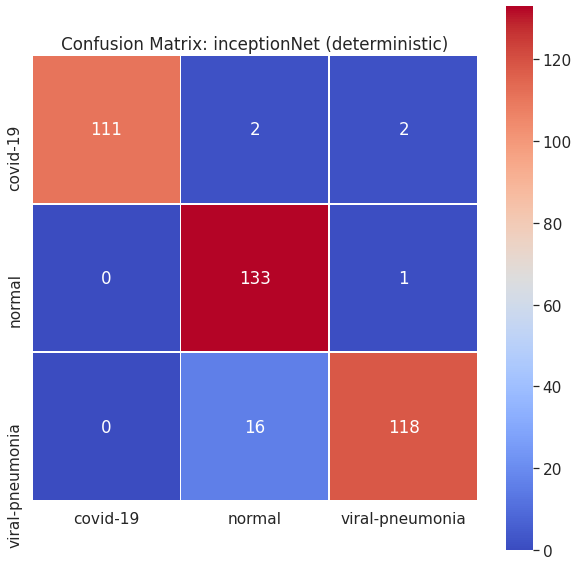

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

sns.set(font_scale=1.4)
plt.figure(figsize=(10,10))
cm = confusion_matrix(true_labels, DETpred, labels = [0, 1, 2])
sns.heatmap(cm,  cmap="coolwarm", annot = True, fmt = "d", linewidths = 1, square = True, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: inceptionNet (deterministic)")
plt.show()

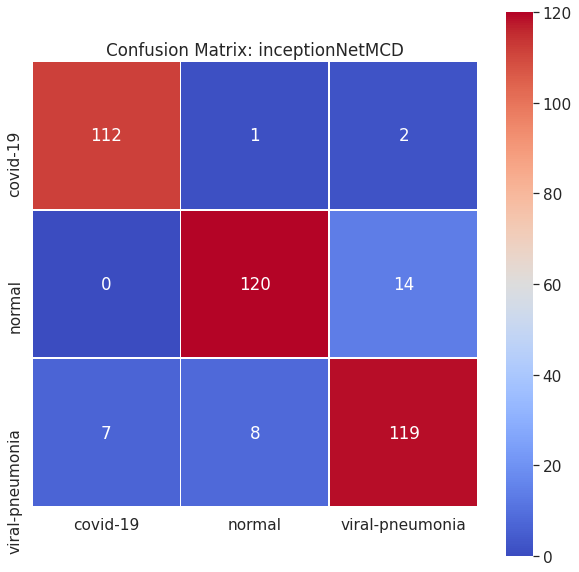

In [ ]:
MCDpred = MCDModel.predict(test_ds) 
MCDpred = np.argmax(MCDpred, axis = 1)

sns.set(font_scale=1.4)
plt.figure(figsize=(10,10))
cm = confusion_matrix(true_labels, MCDpred, labels = [0, 1, 2])
sns.heatmap(cm,  cmap="coolwarm", annot = True, fmt = "d", linewidths = 1, square = True, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix: inceptionNetMCD")
plt.show()

In [ ]:
# prediction uncertainties
softmax_uncertainty_det = compute_uncertainties_softmax(detModel, test_ds)
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.03212269

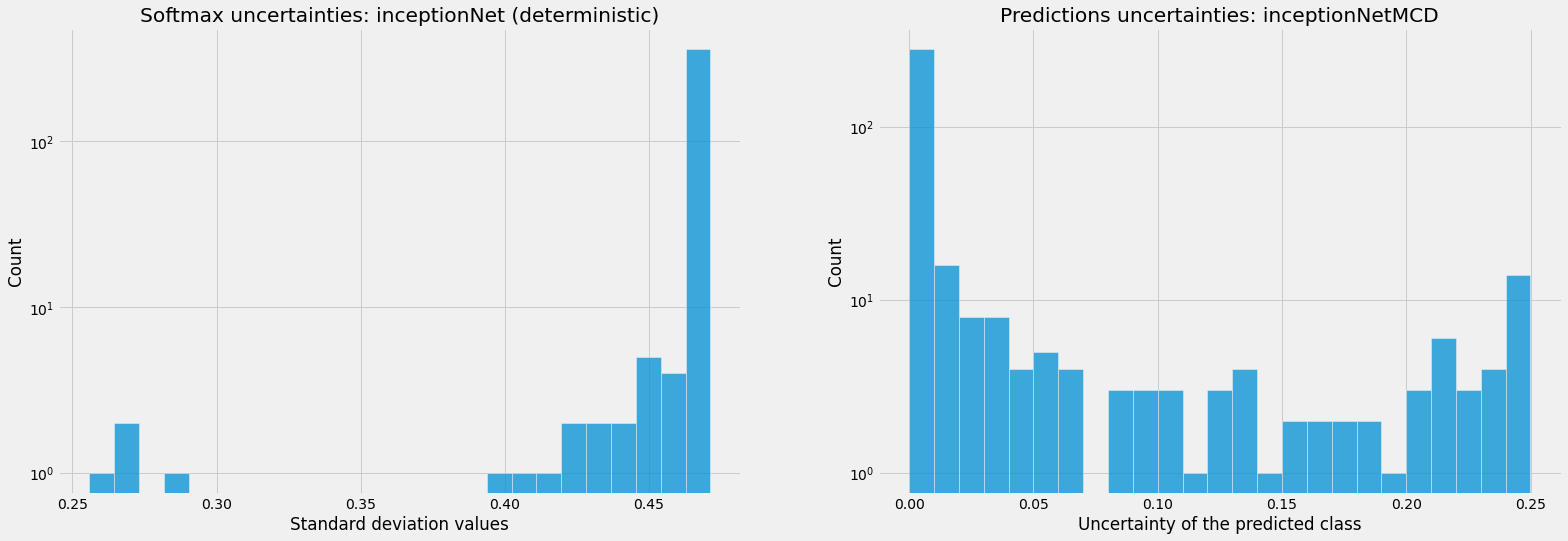

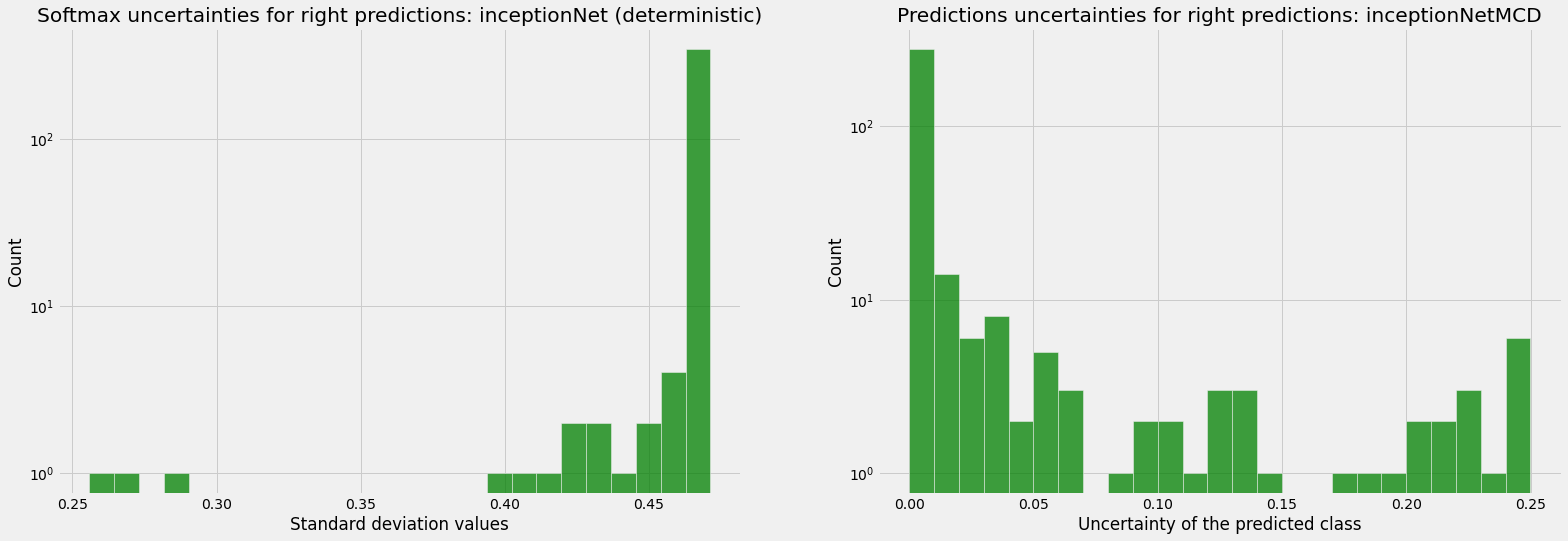

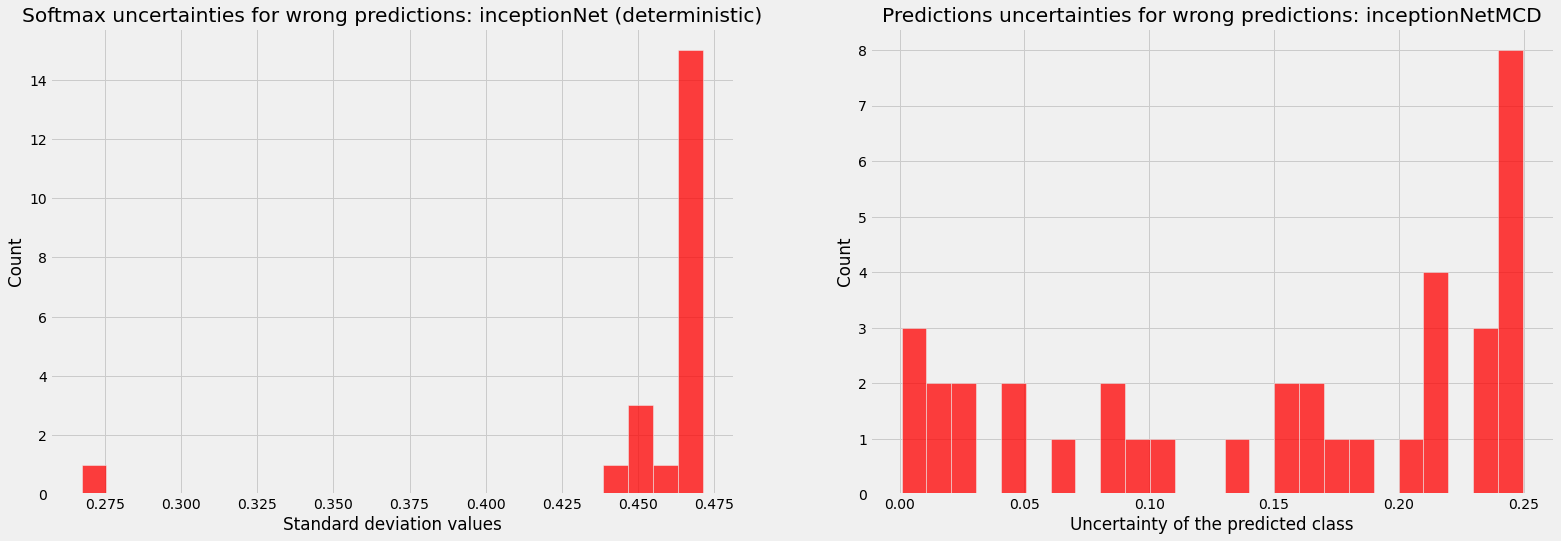

In [ ]:
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, MCDpred)

In [ ]:
sure = np.where(predicted_class_variances_mcd < 0.05)[0]
uncertain = np.where(predicted_class_variances_mcd > 0.22)[0]
print("MCD model")
print("Total predictions: ", len(predicted_class_variances_mcd))
print("Sure predictions: ", len(sure))
print("Unsure predictions: ", len(uncertain))

MCD model
Total predictions:  383
Sure predictions:  288
Unsure predictions:  27


In [ ]:
sure = np.where(softmax_uncertainty_det < 0.25)[0]
uncertain = np.where(softmax_uncertainty_det > 0.40)[0]
print("MCD model")
print("Total predictions: ", len(softmax_uncertainty_det))
print("Sure predictions: ", len(sure))
print("Unsure predictions: ", len(uncertain))

MCD model
Total predictions:  383
Sure predictions:  9
Unsure predictions:  347


## Uncertainty estimation of generative classification models

### MCD model trained with cGAN generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run/1/best'
cGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=cGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run/1/best
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 5s - loss: 0.1814 - accuracy: 0.9426 - recall_15: 0.9478 - recall_16: 0.9104 - recall_17: 0.9701 - precision_15: 1.0000 - precision_16: 0.9606 - precision_17: 0.8966
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.1764 - accuracy: 0.9399 - recall_15: 0.9565 - recall_16: 0.8881 - recall_17: 0.9776 - precision_15: 0.9910 - precision_16: 0.9675 - precision_17: 0.8912
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.1910 - accuracy: 0.9426 - recall_15: 0.9478 - recall_16: 0.9104 - recall_17: 0.9701 - precision_15: 1.0000 - precision_16: 0.9606 - precision_17: 0.8844
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.1943 - accuracy: 0.9478 - recall_15: 0.9304 - recall_16: 0.9104 - recall_17: 1.0000 - precision_15: 0.

In [ ]:
print("Results using inceptionNetMCD trained using cGAN generated data")
cGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN generated data
1/1 [==============================] - 5s 5s/step - loss: 0.2215 - accuracy: 0.9452 - recall_15: 0.9565 - recall_16: 0.9104 - recall_17: 0.9701 - precision_15: 1.0000 - precision_16: 0.9683 - precision_17: 0.8844


[0.22145114839076996,
 0.9451696872711182,
 0.95652174949646,
 0.9104477763175964,
 0.9701492786407471,
 1.0,
 0.9682539701461792,
 0.884353756904602]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(cGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.02417032

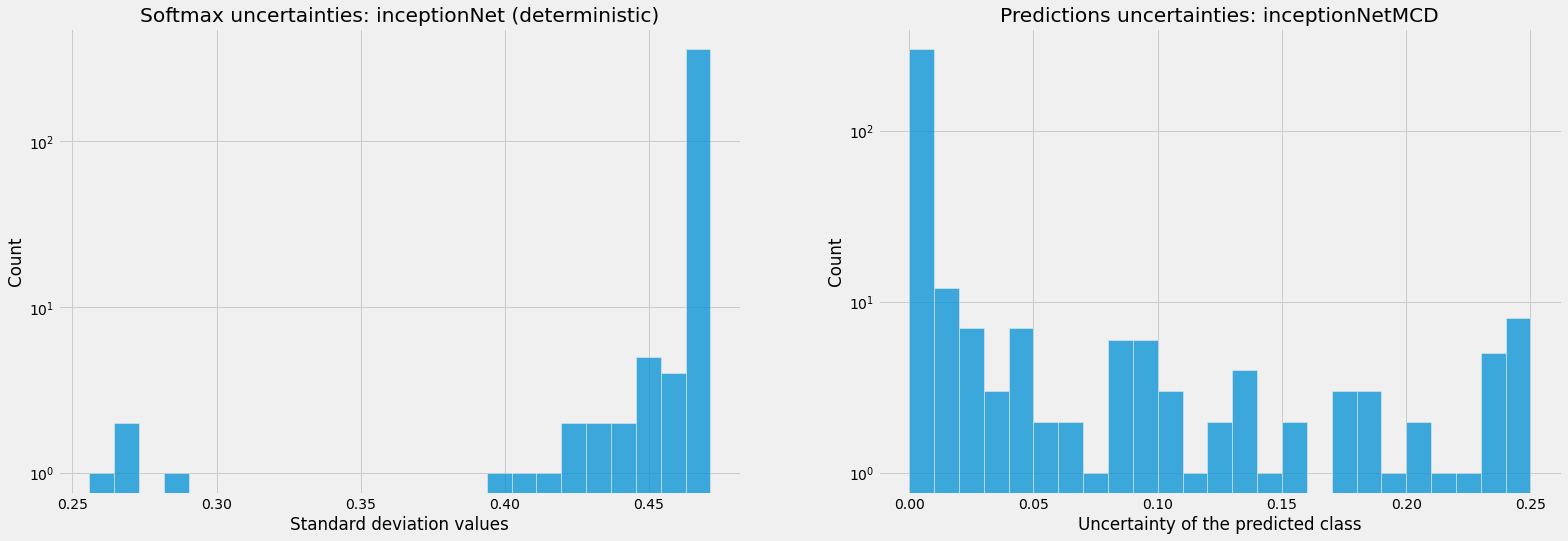

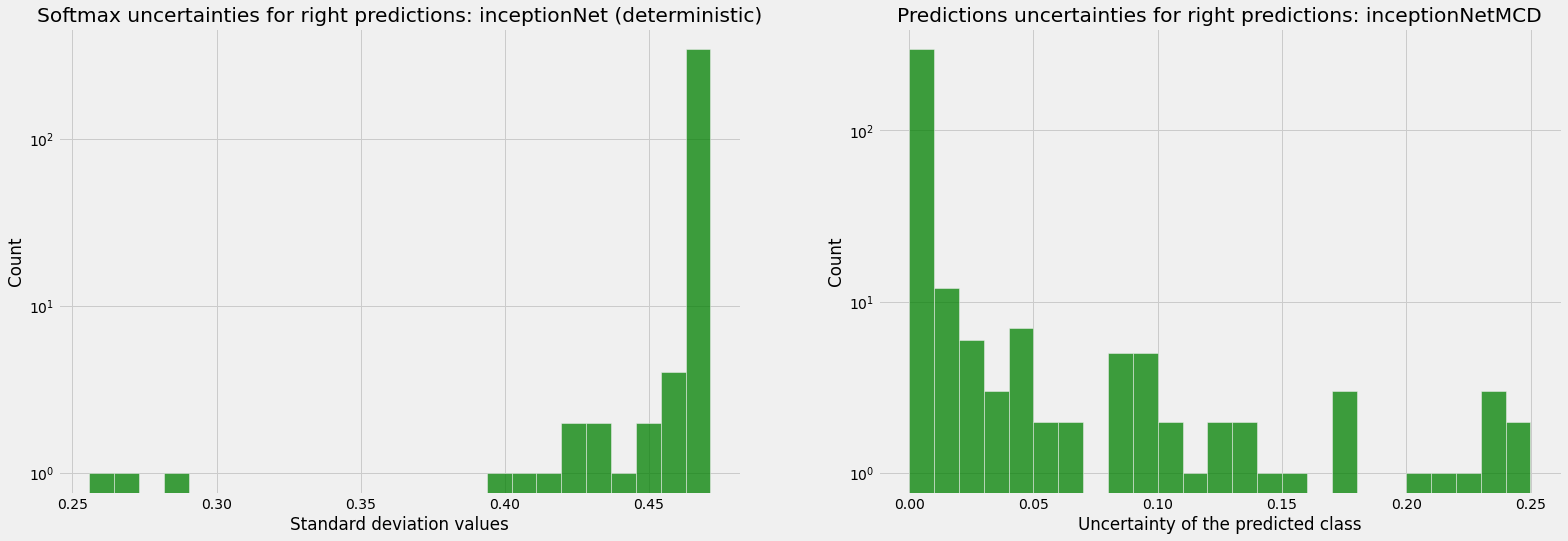

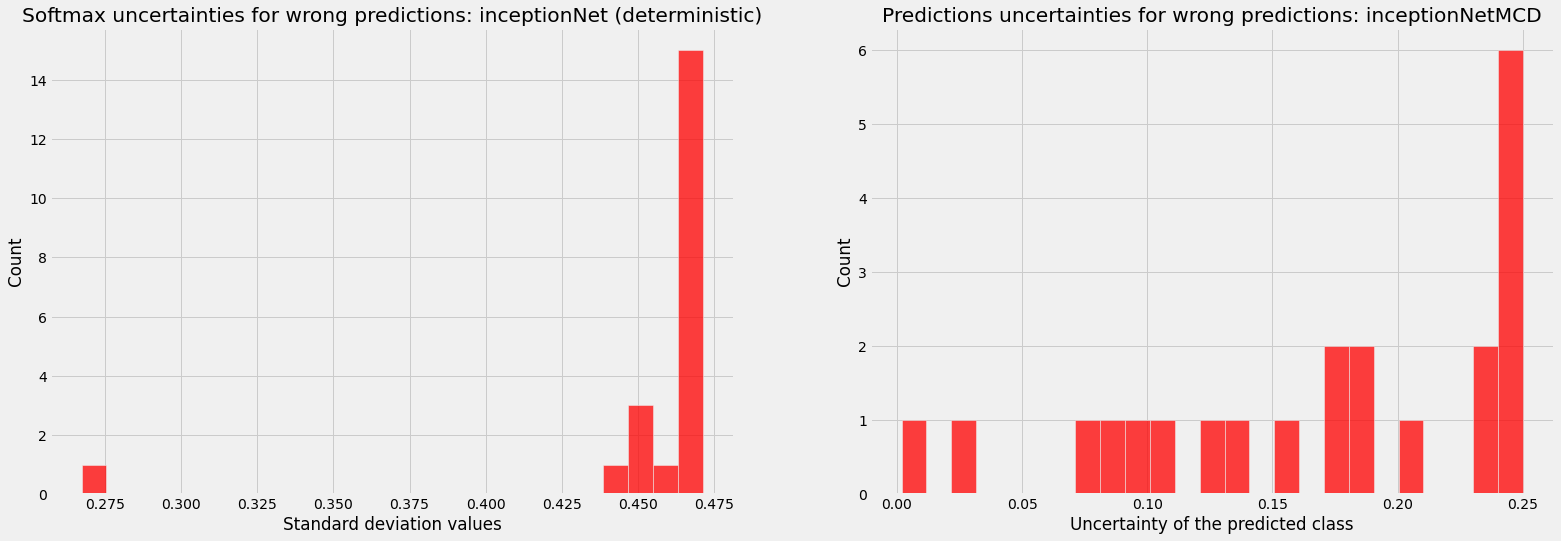

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)

In [ ]:
sure = np.where(predicted_class_variances_mcd < 0.05)[0]
uncertain = np.where(predicted_class_variances_mcd > 0.22)[0]
print("MCD model")
print("Total predictions: ", len(predicted_class_variances_mcd))
print("Sure predictions: ", len(sure))
print("Unsure predictions: ", len(uncertain))

MCD model
Total predictions:  383
Sure predictions:  288
Unsure predictions:  27


In [ ]:
sure = np.where(softmax_uncertainty_det < 0.25)[0]
uncertain = np.where(softmax_uncertainty_det > 0.40)[0]
print("MCD model")
print("Total predictions: ", len(softmax_uncertainty_det))
print("Sure predictions: ", len(sure))
print("Unsure predictions: ", len(uncertain))

MCD model
Total predictions:  383
Sure predictions:  9
Unsure predictions:  347


### MCD model trained with cGAN Min Uncertainty generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run/1/best'
cGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=cGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run/1/best
/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_min_unc_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 5s - loss: 0.2526 - accuracy: 0.9321 - recall_18: 0.9652 - recall_19: 0.8582 - recall_20: 0.9776 - precision_18: 0.9911 - precision_19: 0.9746 - precision_20: 0.8562
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.2869 - accuracy: 0.9321 - recall_18: 0.9739 - recall_19: 0.8507 - recall_20: 0.9776 - precision_18: 0.9912 - precision_19: 0.9744 - precision_20: 0.8562
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.2382 - accuracy: 0.9399 - recall_18: 0.9565 - recall_19: 0.8806 - recall_20: 0.9851 - precision_18: 0.9910 - precision_19: 0.9833 - precision_20: 0.8684
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.2320 - accuracy: 0.9347 - recall_18: 0.9478 - recall_19: 0.8881 - recall_20: 0.9701 - 

In [ ]:
print("Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data")
cGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data
1/1 [==============================] - 1s 641ms/step - loss: 0.2189 - accuracy: 0.9452 - recall_27: 0.9739 - recall_28: 0.8881 - recall_29: 0.9776 - precision_27: 1.0000 - precision_28: 0.9675 - precision_29: 0.8851


[0.21885079145431519,
 0.9451696872711182,
 0.9739130139350891,
 0.888059675693512,
 0.9776119589805603,
 1.0,
 0.9674796462059021,
 0.8851351141929626]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(cGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.019901168

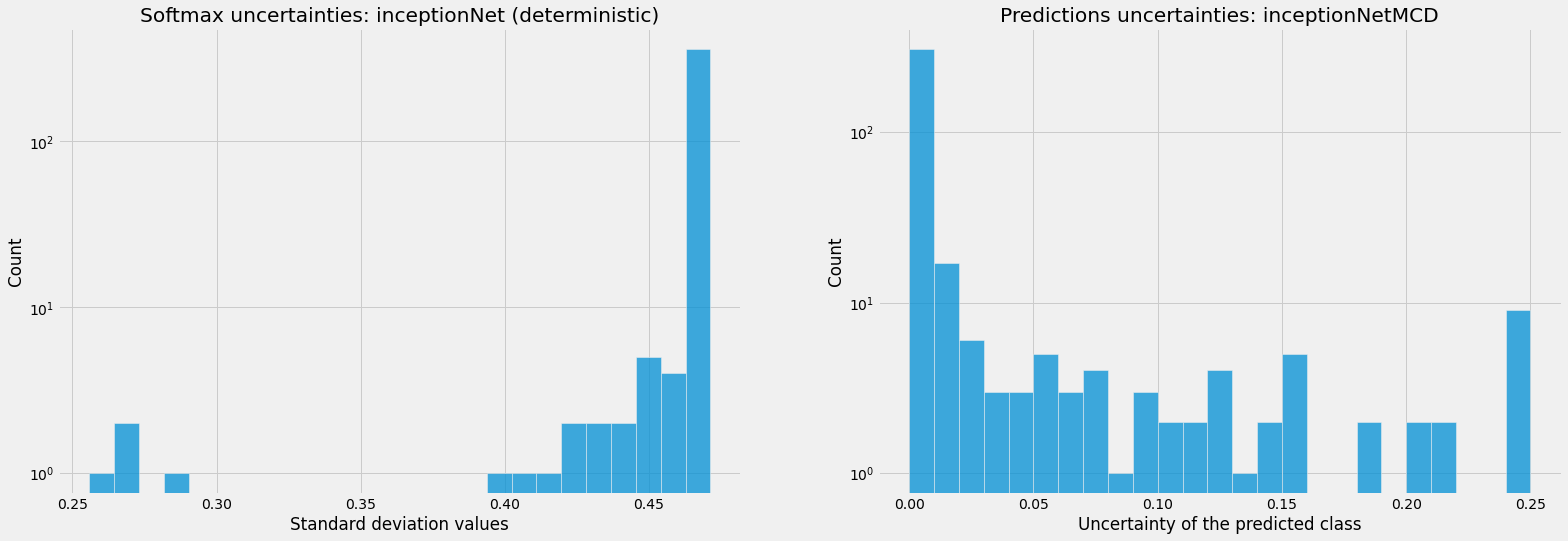

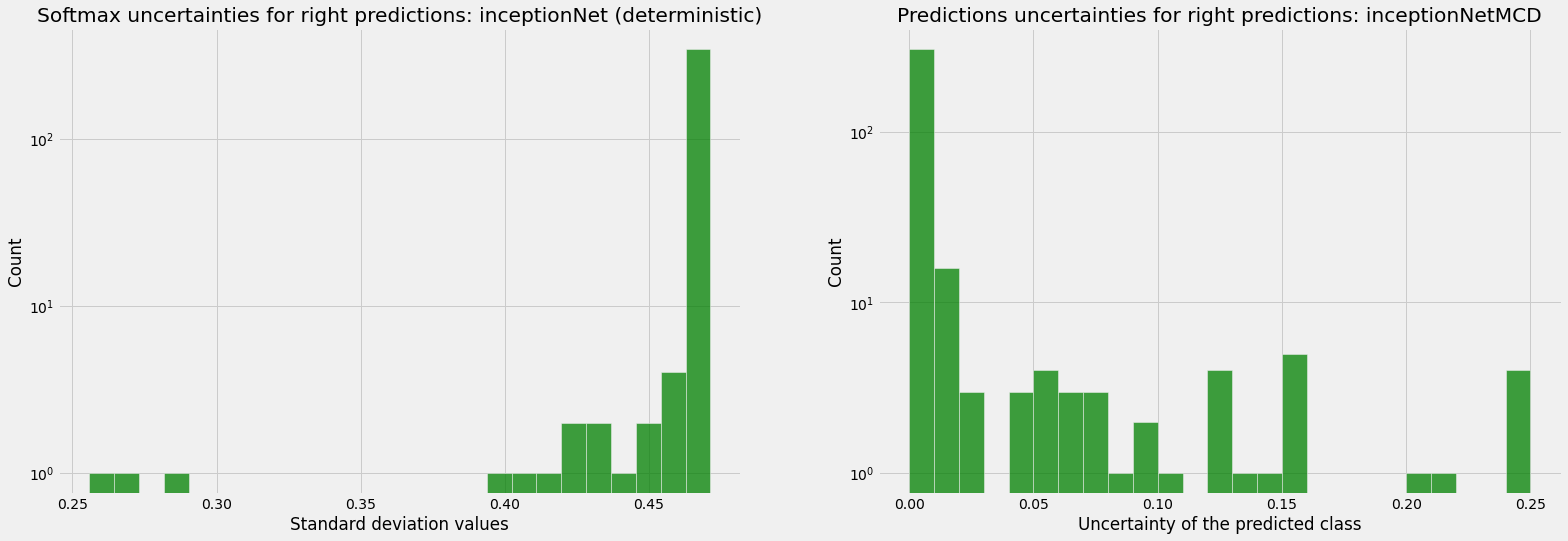

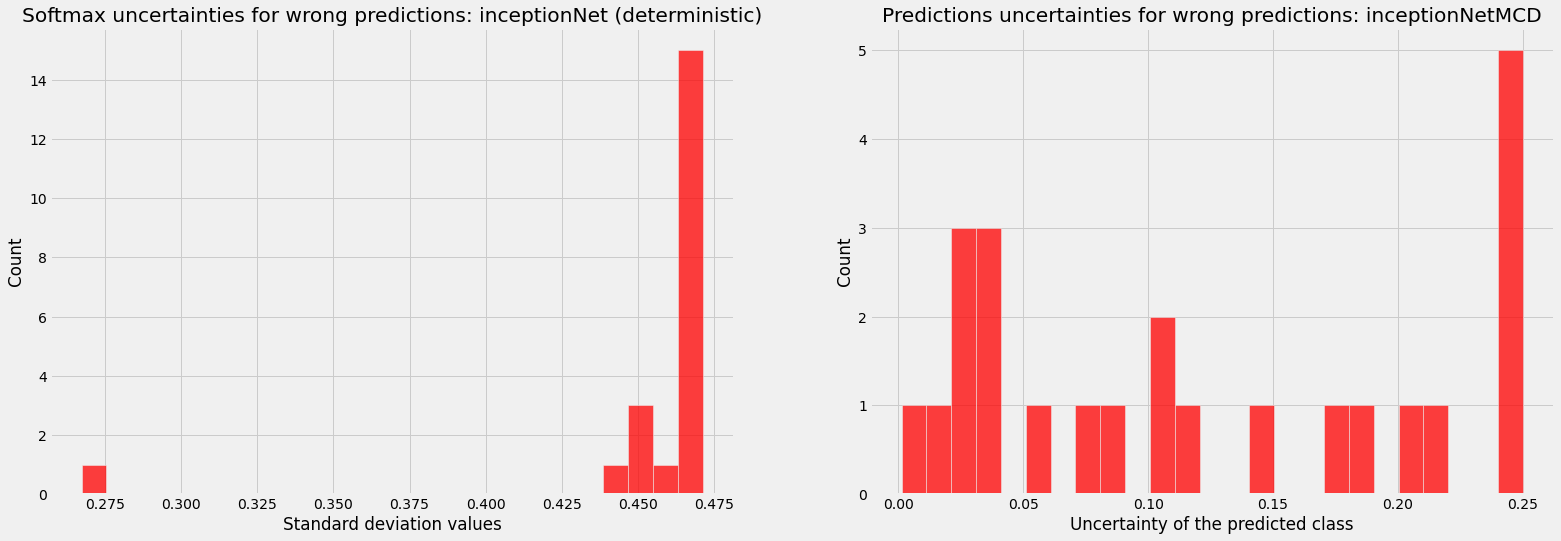

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)

### MCD model trained with cGAN Max Uncertainty generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/mcd_run/1/best'
cGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=cGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/cGAN_max_unc_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 4s - loss: 0.3478 - accuracy: 0.9295 - recall_21: 0.9391 - recall_22: 0.8507 - recall_23: 0.9925 - precision_21: 0.9818 - precision_22: 0.9828 - precision_23: 0.8581
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.3619 - accuracy: 0.9399 - recall_21: 0.9478 - recall_22: 0.8806 - recall_23: 0.9925 - precision_21: 0.9909 - precision_22: 0.9833 - precision_23: 0.8693
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.3247 - accuracy: 0.9426 - recall_21: 0.9652 - recall_22: 0.8731 - recall_23: 0.9925 - precision_21: 0.9823 - precision_22: 0.9915 - precision_23: 0.8750
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.2709 - accuracy: 0.9452 - recall_21: 0.9565 - recall_22: 0.8806 - recall_23: 0.9925 - precision_21: 1.0000 - precision_22: 0.9916 - precision_23: 0.8693
--------------- TRIAL 5 -------------

In [ ]:
print("Results using inceptionNetMCD trained using cGAN Max Uncertainty generated data")
cGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN Max Uncertainty generated data
1/1 [==============================] - 1s 650ms/step - loss: 0.3768 - accuracy: 0.9426 - recall_42: 0.9652 - recall_43: 0.8657 - recall_44: 0.9925 - precision_42: 0.9911 - precision_43: 0.9831 - precision_44: 0.8750


[0.37681758403778076,
 0.942558765411377,
 0.9652174115180969,
 0.8656716346740723,
 0.9925373196601868,
 0.9910714030265808,
 0.9830508232116699,
 0.875]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(cGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.018845957

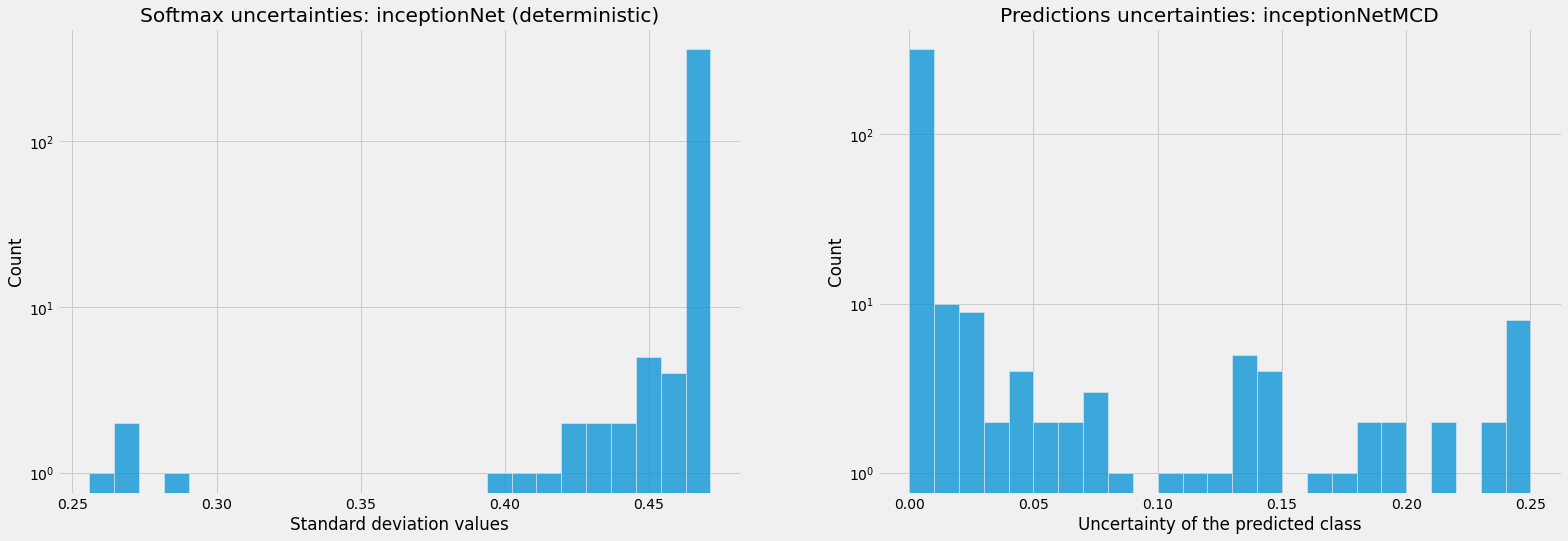

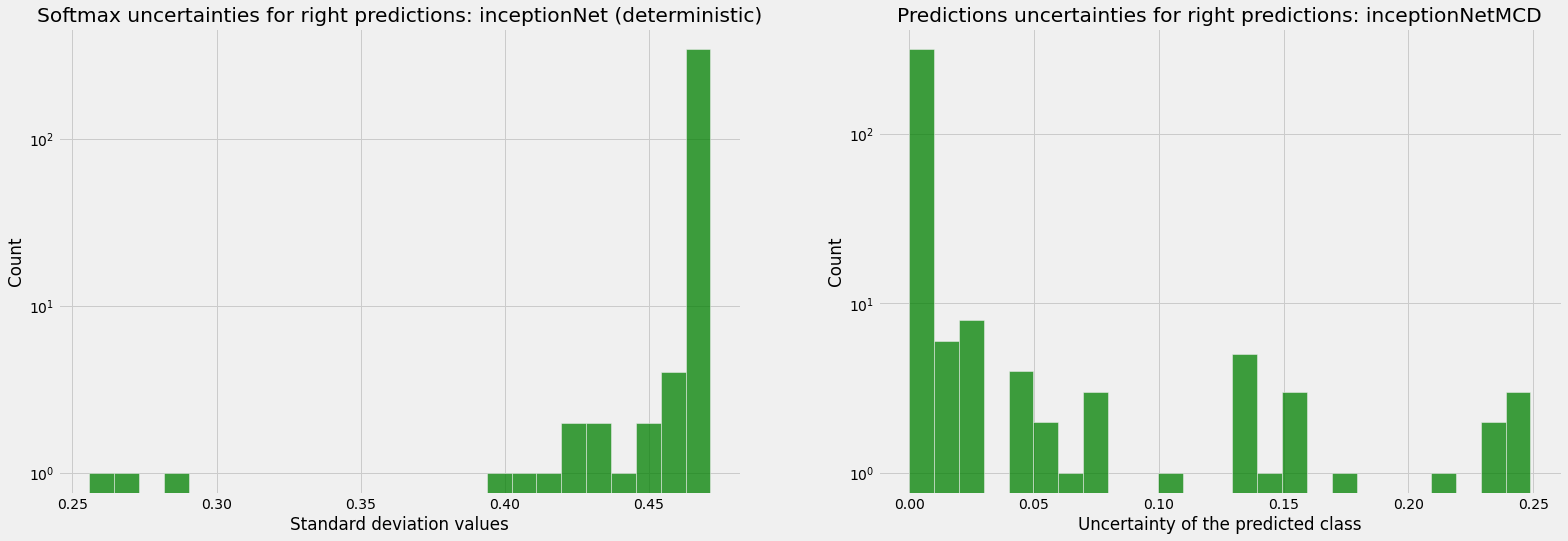

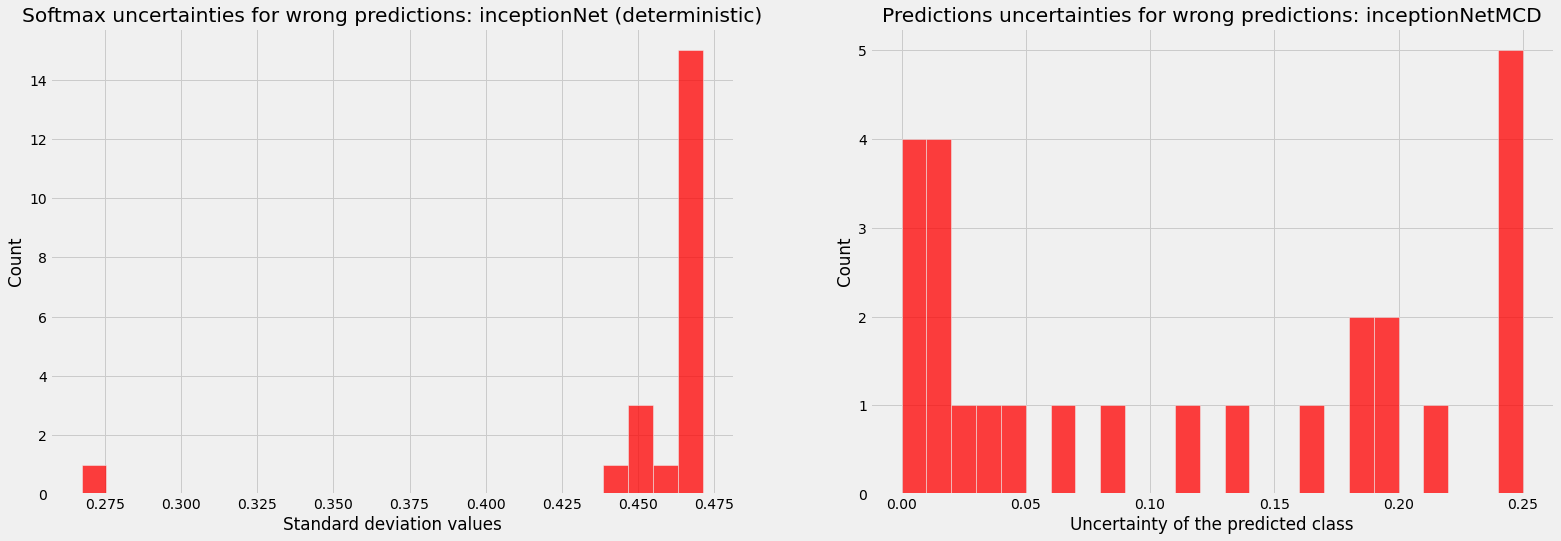

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)

### MCD model trained with AC-cGAN generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/mcd_run/1/best'
ACcGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=ACcGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 4s - loss: 0.2626 - accuracy: 0.9295 - recall_24: 0.9565 - recall_25: 0.9403 - recall_26: 0.8955 - precision_24: 0.9821 - precision_25: 0.8873 - precision_26: 0.9302
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.2494 - accuracy: 0.9269 - recall_24: 0.9565 - recall_25: 0.9030 - recall_26: 0.9254 - precision_24: 1.0000 - precision_25: 0.9098 - precision_26: 0.8857
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.2942 - accuracy: 0.9217 - recall_24: 0.9391 - recall_25: 0.9179 - recall_26: 0.9030 - precision_24: 0.9818 - precision_25: 0.8978 - precision_26: 0.8963
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.2589 - accuracy: 0.9243 - recall_24: 0.9478 - recall_25: 0.9030 - recall_26: 0.9179 - precision_24: 1.0000 - precision_25: 0.9098 - precision_26: 0.8849
--------------- TRIAL 5 --------------- 
3

In [ ]:
print("Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data")
ACcGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data
1/1 [==============================] - 1s 653ms/step - loss: 0.2517 - accuracy: 0.9321 - recall_45: 0.9478 - recall_46: 0.9328 - recall_47: 0.9179 - precision_45: 1.0000 - precision_46: 0.9058 - precision_47: 0.9044


[0.2516658902168274,
 0.9321148991584778,
 0.947826087474823,
 0.9328358173370361,
 0.9179104566574097,
 1.0,
 0.9057971239089966,
 0.904411792755127]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(ACcGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.031034134

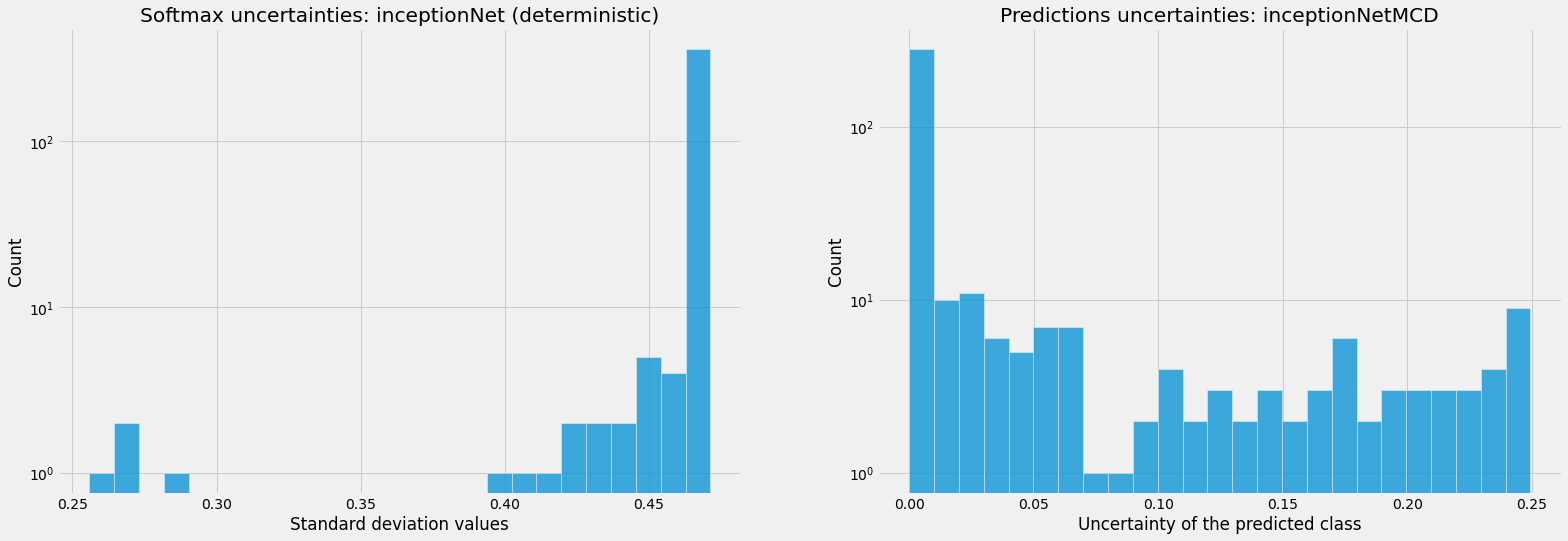

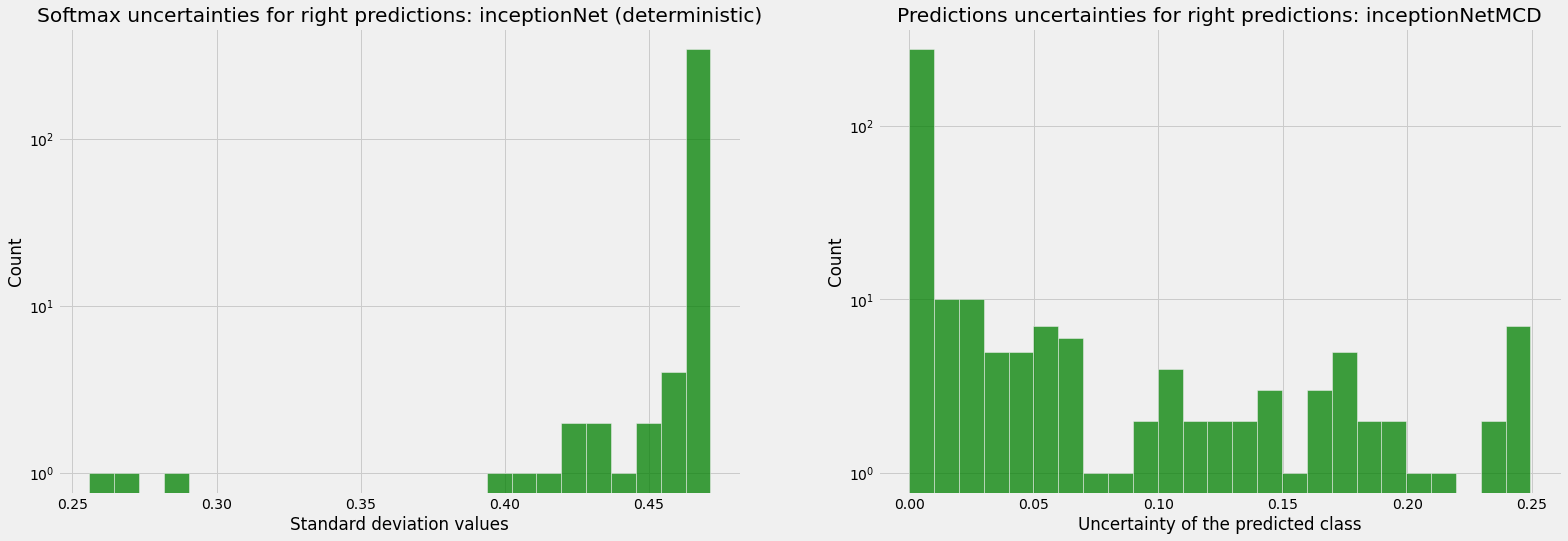

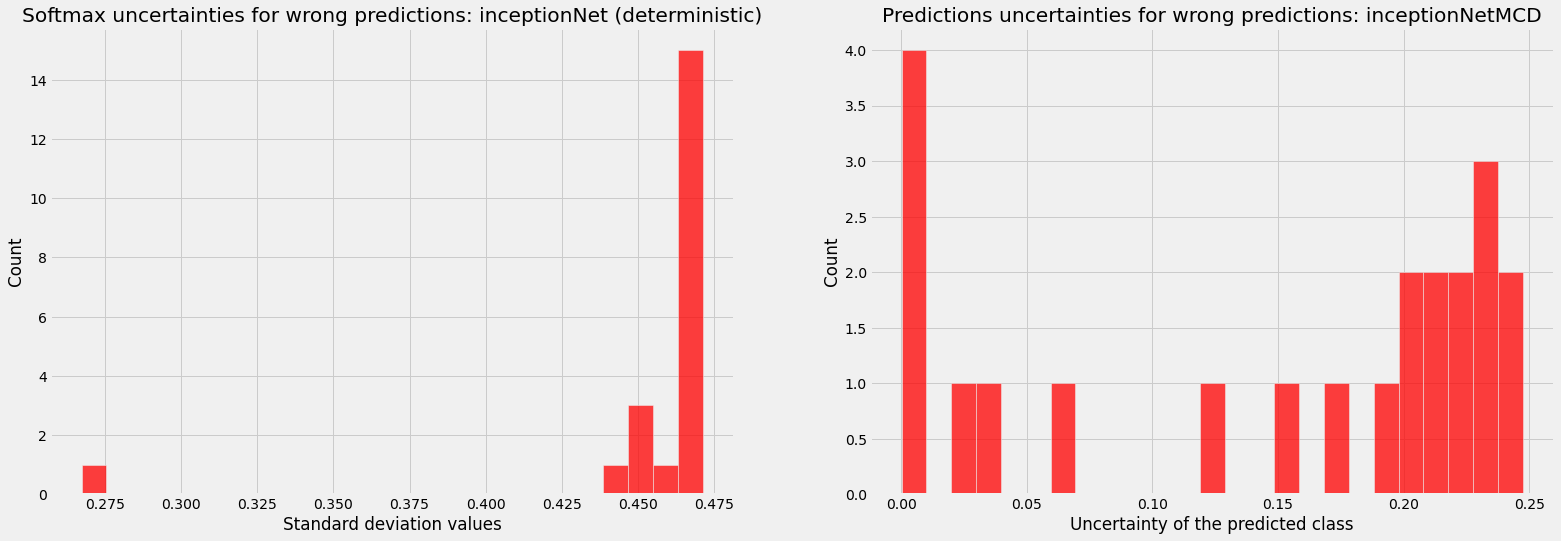

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)

### MCD model trained with AC-cGAN Min Unc generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/mcd_run/1/best'
ACcGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=ACcGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_min_unc_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 5s - loss: 0.2885 - accuracy: 0.9164 - recall_27: 0.9739 - recall_28: 0.8657 - recall_29: 0.9179 - precision_27: 0.9655 - precision_28: 0.9134 - precision_29: 0.8786
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.2881 - accuracy: 0.9112 - recall_27: 0.9478 - recall_28: 0.8731 - recall_29: 0.9179 - precision_27: 0.9646 - precision_28: 0.9141 - precision_29: 0.8662
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.2433 - accuracy: 0.9086 - recall_27: 0.9565 - recall_28: 0.8731 - recall_29: 0.9030 - precision_27: 0.9565 - precision_28: 0.9141 - precision_29: 0.8705
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.2778 - accuracy: 0.8956 - recall_27: 0.9565 - recall_28: 0.8657 - recall_29: 0.8731 - precision_27: 0.9565 - precision_28: 0.8788 - precision_29: 0.8667
--------------- TRIAL 5 ----------

In [ ]:
print("Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data")
ACcGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data
1/1 [==============================] - 4s 4s/step - loss: 0.2751 - accuracy: 0.9112 - recall_51: 0.9478 - recall_52: 0.8881 - recall_53: 0.8955 - precision_51: 0.9561 - precision_52: 0.9015 - precision_53: 0.8824


[0.2751220762729645,
 0.9112271666526794,
 0.947826087474823,
 0.888059675693512,
 0.89552241563797,
 0.9561403393745422,
 0.9015151262283325,
 0.8823529481887817]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(ACcGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.02924213

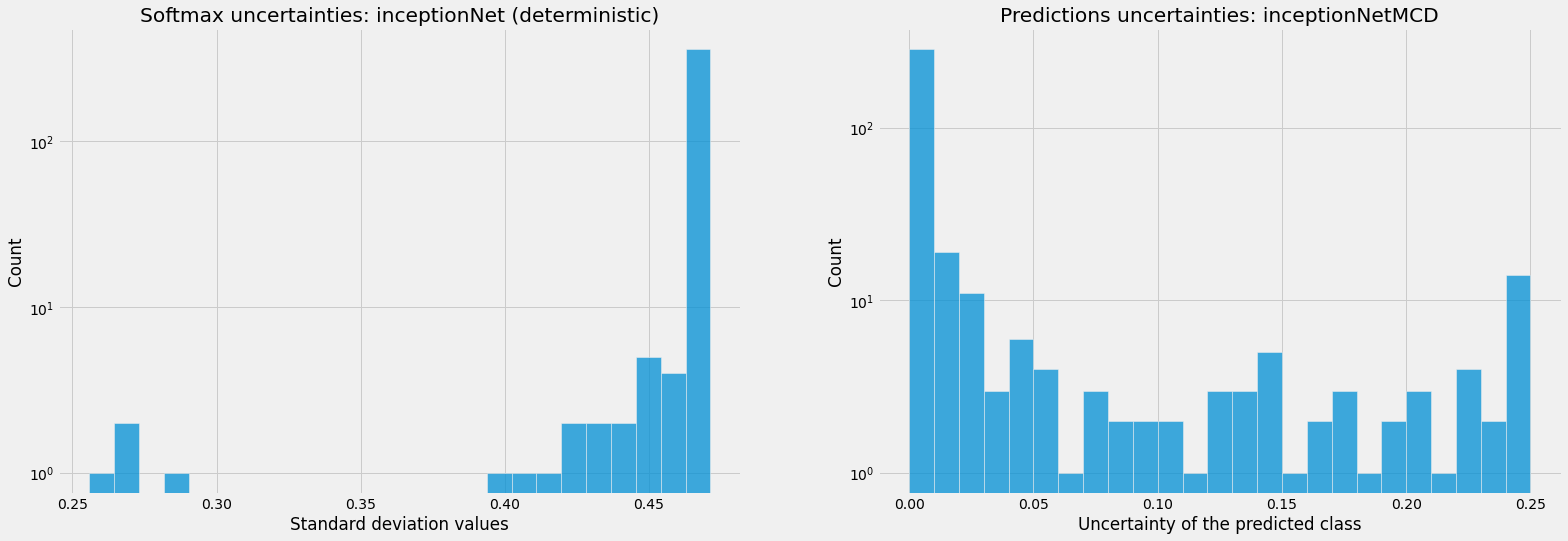

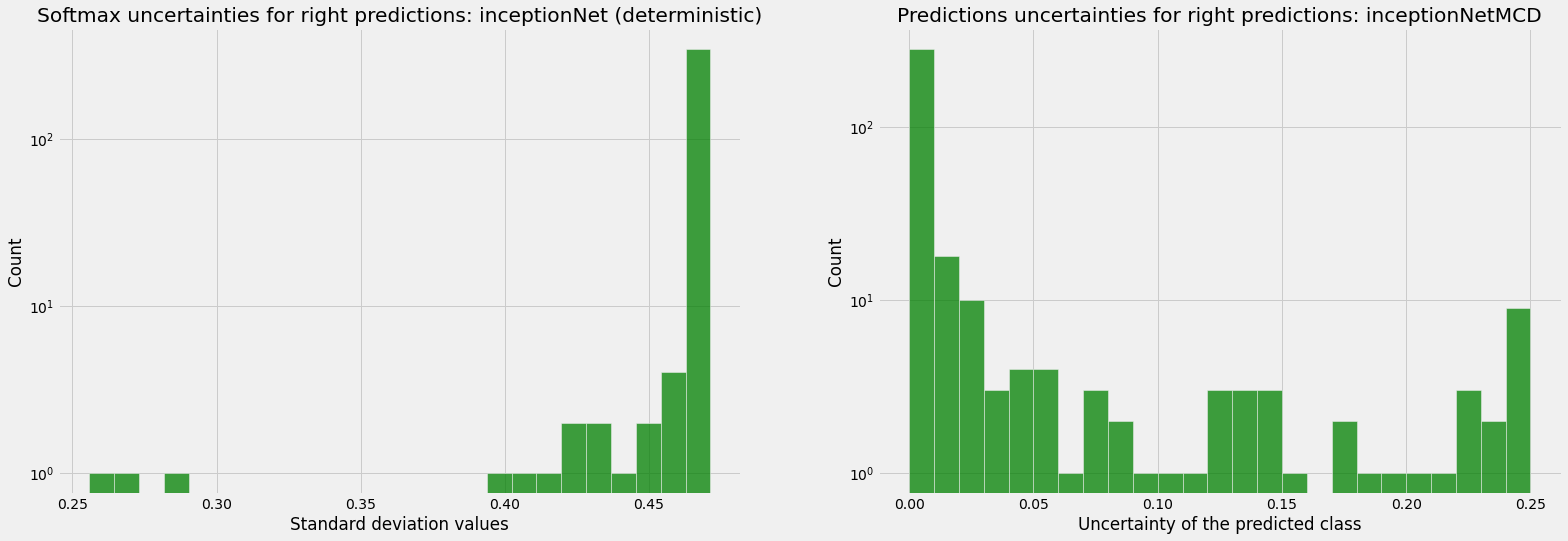

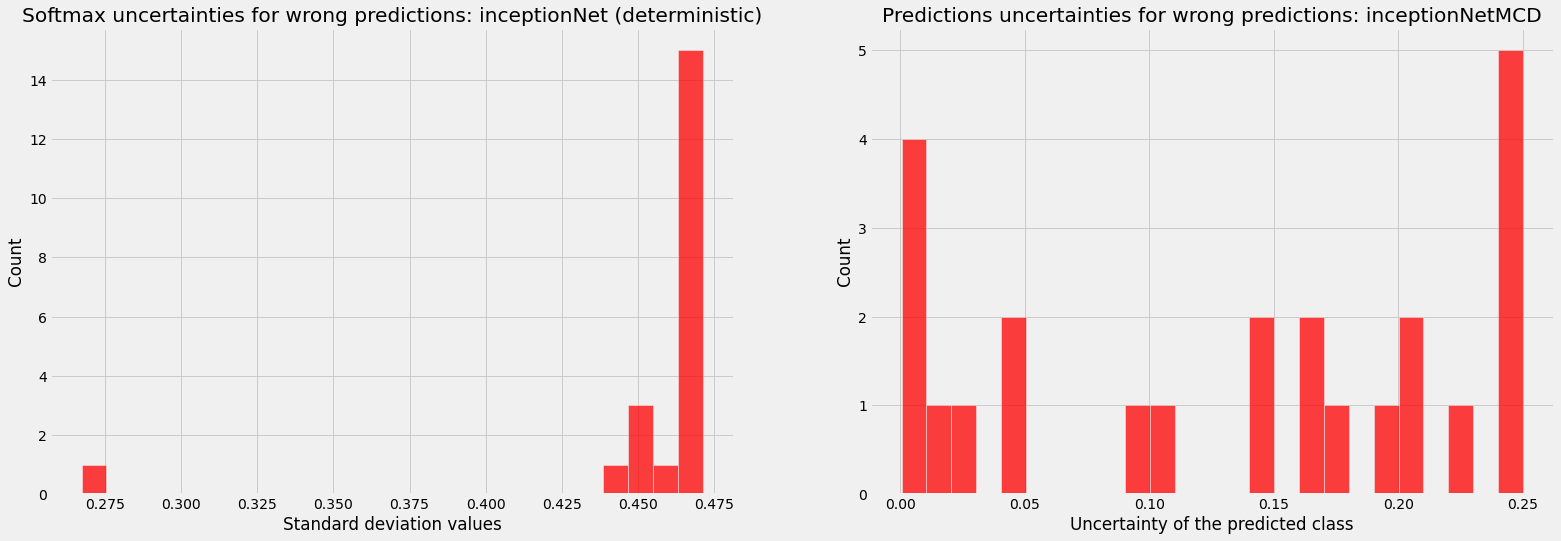

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)

### MCD model trained with AC-cGAN Max Unc generated data

In [ ]:
weights_path = '/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/mcd_run/1/best'
ACcGAN_MCDModel = inceptionNetMCD()
checkpoint = tf.train.Checkpoint(model=ACcGAN_MCDModel)

best = tf.train.latest_checkpoint(weights_path)
print(best)
checkpoint.restore(best)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/mcd_run/1/best/ckpt-1


In [ ]:
results = evaluate_model('/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/mcd_run/1/best', test_ds, baseline=False)

/content/drive/MyDrive/BIOINF/checkpoints_classification/modelInc/AC-cGAN_max_unc_half_data/mcd_run/1/best/ckpt-1
--------------- TRIAL 1 --------------- 
3/3 - 5s - loss: 0.2292 - accuracy: 0.9347 - recall_30: 0.9652 - recall_31: 0.9179 - recall_32: 0.9254 - precision_30: 0.9911 - precision_31: 0.8978 - precision_32: 0.9254
--------------- TRIAL 2 --------------- 
3/3 - 1s - loss: 0.2410 - accuracy: 0.9426 - recall_30: 0.9652 - recall_31: 0.9328 - recall_32: 0.9328 - precision_30: 0.9911 - precision_31: 0.9191 - precision_32: 0.9328
--------------- TRIAL 3 --------------- 
3/3 - 1s - loss: 0.2562 - accuracy: 0.9217 - recall_30: 0.9565 - recall_31: 0.8955 - recall_32: 0.9104 - precision_30: 0.9910 - precision_31: 0.8824 - precision_32: 0.9037
--------------- TRIAL 4 --------------- 
3/3 - 1s - loss: 0.2492 - accuracy: 0.9217 - recall_30: 0.9652 - recall_31: 0.9104 - recall_32: 0.8955 - precision_30: 0.9911 - precision_31: 0.8777 - precision_32: 0.9160
--------------- TRIAL 5 ----------

In [ ]:
print("Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data")
ACcGAN_MCDModel.evaluate(test_ds, verbose=1)

Results using inceptionNetMCD trained using cGAN Min Uncertainty generated data
1/1 [==============================] - 5s 5s/step - loss: 0.2082 - accuracy: 0.9295 - recall_48: 0.9652 - recall_49: 0.9179 - recall_50: 0.9104 - precision_48: 0.9911 - precision_49: 0.8913 - precision_50: 0.9173


[0.20822817087173462,
 0.9295039176940918,
 0.9652174115180969,
 0.9179104566574097,
 0.9104477763175964,
 0.9910714030265808,
 0.8913043737411499,
 0.9172932505607605]

In [ ]:
predictions_uncertainty_mcd, predicted_class_variances_mcd = compute_uncertainties(ACcGAN_MCDModel, test_ds, MC=100)

In [ ]:
# Mean Uncertainty
predicted_class_variances_mcd.mean()

0.034941737

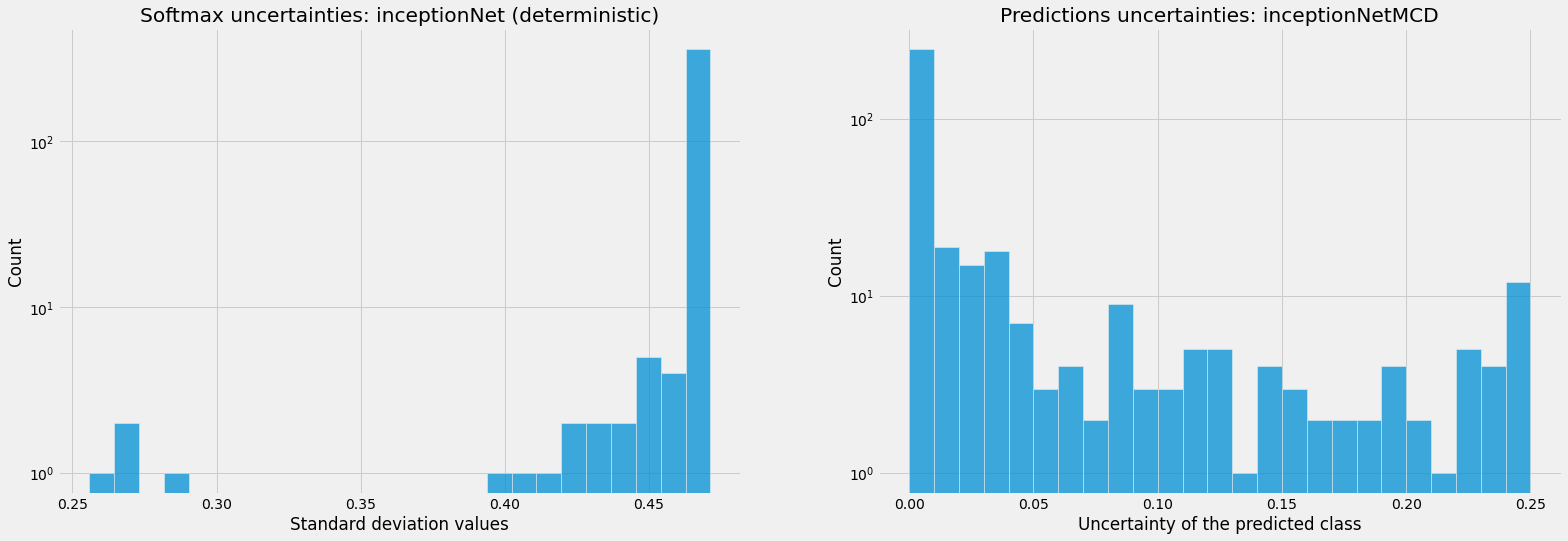

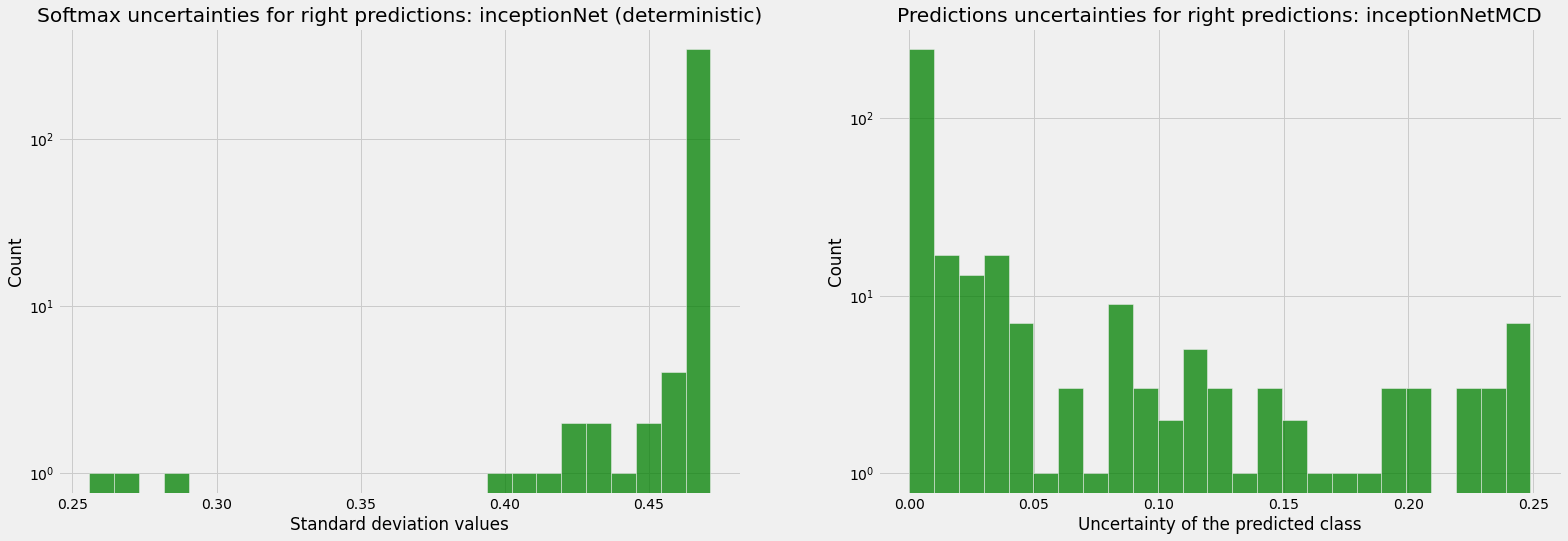

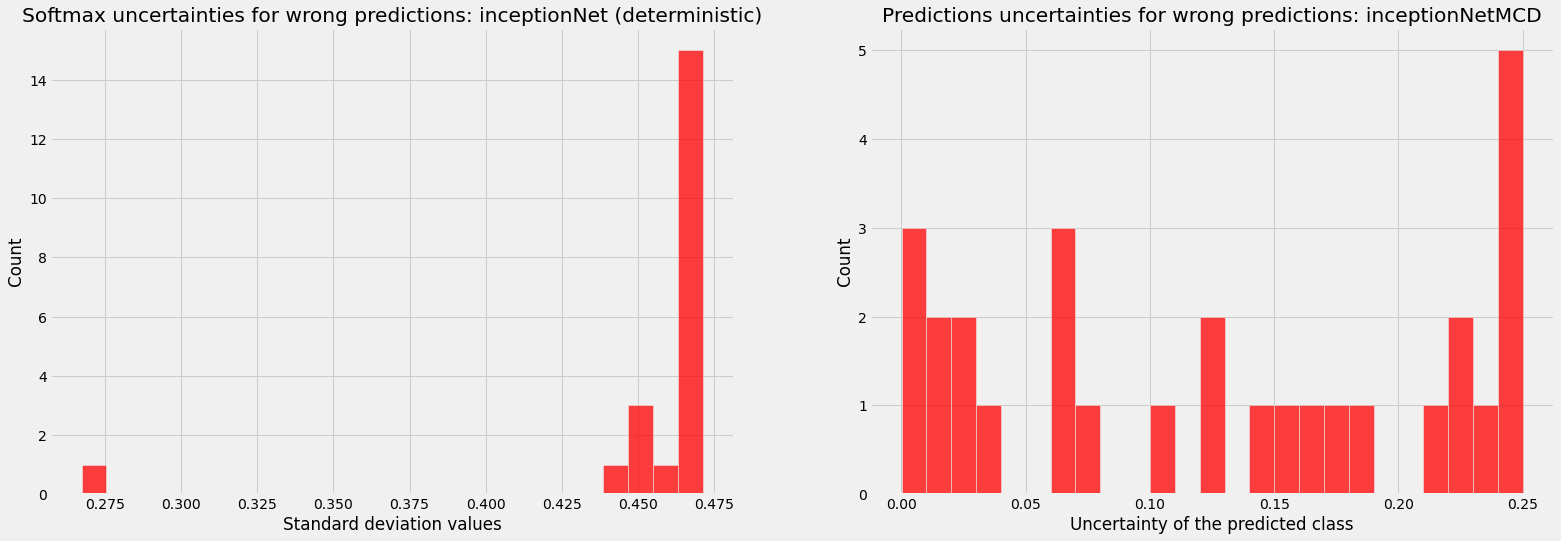

In [ ]:
DETpred = detModel.predict(test_ds) 
DETpred = np.argmax(DETpred, axis = 1)

cGAN_MCDpred = cGAN_MCDModel.predict(test_ds) 
cGAN_MCDpred = np.argmax(cGAN_MCDpred, axis = 1)
plot_results(softmax_uncertainty_det, predicted_class_variances_mcd, true_labels, DETpred, cGAN_MCDpred)